In [1]:
import torch.nn as nn
import torch
from skorch import NeuralNetRegressor

In [2]:
pip install gensim


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub
import pandas as pd
import os
# Download latest version
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")
df = pd.read_csv(os.path.join(path,"postings.csv"))

In [4]:
# Drop NA
salary_df = df[df["max_salary"].notna() & df["min_salary"].notna() & df["description"].notna()]

# Convert Salary
salary_scale = {
    "HOURLY": 2080,
    "WEEKLY": 52,
    "BIWEEKLY": 26,
    "MONTHLY":12
}
for period, scale in salary_scale.items():
    salary_df.loc[salary_df['pay_period'] == period, 'max_salary'] *= scale
    salary_df.loc[salary_df['pay_period'] == period, 'min_salary'] *= scale
    salary_df.loc[salary_df['pay_period'] == period, 'pay_period'] = "YEARLY"

In [5]:
salary_df.head()
salary_df["total_text"] = salary_df["title"] + ' ' + salary_df["description"] + ' ' + salary_df["location"]


/var/folders/v2/xp28m4jj3z7fyzyg9t6k4vhh0000gn/T/ipykernel_70439/3107211692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_df["total_text"] = salary_df["title"] + ' ' + salary_df["description"] + ' ' + salary_df["location"]


In [8]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_data = [TaggedDocument(words=row.split(), tags=[str(idx)]) for idx, row in enumerate(salary_df["total_text"])]

model = Doc2Vec(
    tagged_data,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=50
)

In [9]:
salary_df["total_text_embedding"] = salary_df["total_text"].apply(lambda x: model.infer_vector(x.split()))


/var/folders/v2/xp28m4jj3z7fyzyg9t6k4vhh0000gn/T/ipykernel_70439/4267273411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary_df["total_text_embedding"] = salary_df["total_text"].apply(lambda x: model.infer_vector(x.split()))


In [10]:
len(salary_df["total_text_embedding"][0])

100

In [11]:
embedding_df = pd.DataFrame(salary_df.total_text_embedding.tolist(), index= salary_df.index)
# salary_df["title_embedding"].expand()

In [12]:
embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.694683,0.865375,2.282574,-0.794019,0.593003,0.625274,-0.921012,2.866505,-0.854692,0.630137,...,1.836867,2.031727,1.181382,-1.867819,0.816332,-0.033002,0.024172,-0.243023,-0.258751,0.231454
1,1.652920,0.186538,0.364717,0.067389,0.254172,0.103366,0.897945,0.178558,-0.252527,-0.584056,...,-1.199359,0.392673,0.146852,1.642371,-1.102911,-1.728072,-0.691653,0.034622,-0.014266,1.394683
2,0.088563,-0.224883,0.898321,0.318269,-0.246781,0.753944,-0.534108,-0.781828,-0.139442,-0.139091,...,1.537994,0.502857,0.874350,1.460307,0.626443,-1.058402,0.034356,-0.341452,0.072173,-1.710911
3,3.298724,-0.023606,-0.648947,-1.317897,0.644221,0.097414,-1.454066,1.894466,-2.776237,0.459424,...,-0.426094,0.126908,-0.300029,0.299881,1.246894,1.562214,-0.626316,-1.927689,-0.556858,-0.270053
4,-0.388657,0.048377,-1.010404,-0.435014,-0.738284,-1.200384,1.042996,-0.580794,0.734438,0.274401,...,0.963159,0.418106,0.793093,0.237929,-0.050725,-0.067036,0.110754,-0.120978,-1.351762,-0.649635


In [13]:
embedding_df.to_csv("../linkedin_embeddings/doc2vec_total-result.csv")

# Train

In [ ]:
embedding_df = pd.read_csv("../linkedin_embeddings/doc2vec_total-result.csv")

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embedding_df.to_numpy(),salary_df["max_salary"].to_numpy())

## XGBoost

In [8]:
# from sklearn.ensemble import GradientBoostingRegressor
# clf = GradientBoostingRegressor(n_estimators=500, max_depth=5, random_state=0)

import xgboost as xg 

clf = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 500, max_depth=5, seed = 123)
clf.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
y_pred = clf.predict(X_test)

In [10]:
type(X_test)

numpy.ndarray

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

8776804.06419026


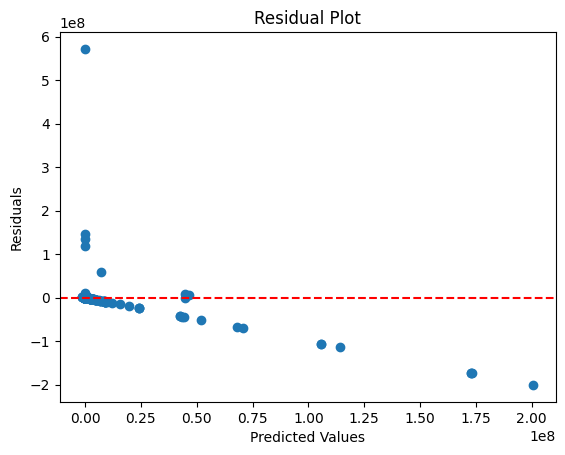

In [ ]:

# scale = 1
# y_pred_scale = y_pred / scale
residuals = y_test - y_pred

# filter_idx = (residuals < 1e7) & (residuals > -3e7)
# filter_idx = (residuals < 5e7) & (residuals > -5e7)
# filter_idx = (residuals > -1e5)

# rmse = root_mean_squared_error(y_pred_scale[filter_idx], y_test[filter_idx])
rmse = root_mean_squared_error(y_pred, y_test)
print(rmse)

# residuals[residuals < 5e7]
# Plot the residuals
# plt.scatter(y_pred_scale[filter_idx], residuals[filter_idx])
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [12]:
pd.DataFrame(residuals).describe()

,0
count,7.448000e+03
mean,-1.039392e+05
std,8.776778e+06
min,-2.005319e+08
25%,-3.551065e+04
50%,-3.426391e+03
75%,2.687498e+04
max,5.718176e+08


## MLP

In [ ]:
class MLPRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, dropout=0.3):
        super(MLPRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 1)
        )

    def forward(self, x):
        return self.model(x)

In [26]:
clf = NeuralNetRegressor(
    MLPRegression,
    module__input_dim=X_train.shape[1],
    max_epochs=200,
    lr=0.001,
    optimizer=torch.optim.Adam
)
clf.fit(X_train.astype('float32'), y_train.astype('float32').reshape(-1, 1))

  epoch           train_loss         valid_loss     dur
-------  -------------------  -----------------  ------
      1  36290167814127.6172  457596168979.0754  0.1946
      2  36264735234812.6641  462157569700.1746  0.1878
      3  36265068140589.4844  462347547203.7091  0.1722
      4  36265629307925.9375  462587727093.4025  0.1818
      5  36264257256056.4453  462670538768.9559  0.1717
      6  36264434441345.2969  462899613529.6487  0.1919
      7  36265719578373.0859  462583855655.7548  0.1756
      8  36263014366997.1250  463492871679.1981  0.1825
      9  36262706947438.0078  463299720532.7223  0.1740
     10  36264159497550.1562  462378892953.6344  0.1743
     11  36267030301950.1797  461680951912.8288  0.1839
     12  36265032720218.6719  463184359399.2535  0.1843
     13  36262884057017.8828  463322798793.5234  0.1859
     14  36263696229780.5000  463262610771.3475  0.1753
     15  36266278404013.3906  462352832859.8254  0.1736
     16  36267524094843.3828  461833042928.1898 

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLPRegression(
    (model): Sequential(
      (0): Linear(in_features=385, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Linear(in_features=64, out_features=1, bias=True)
    )
  ),
)

In [37]:
y_pred = clf.predict(X_test.astype('float32'))

7837082.858895481


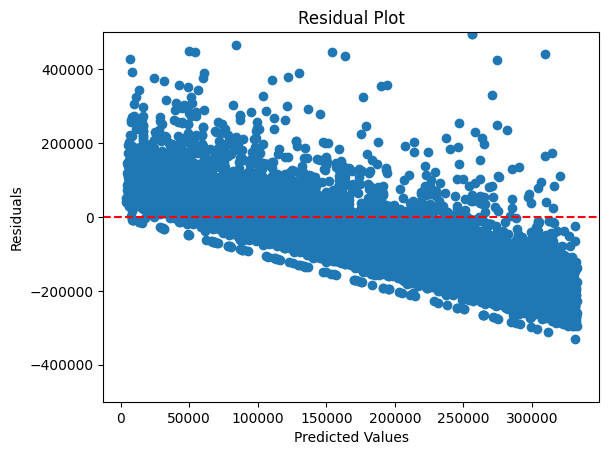

In [45]:

residuals = y_test.reshape(-1, 1) - y_pred

rmse = root_mean_squared_error(y_pred, y_test)
print(rmse)

plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')

plt.ylim(-500000, 500000)

plt.show()

In [40]:
pd.DataFrame(residuals).describe()

,0
count,7.448000e+03
mean,1.837680e+05
std,7.835454e+06
min,-3.309498e+05
25%,-1.354489e+05
50%,-4.779158e+04
75%,3.119999e+04
max,4.086000e+08
